# Root Insurance Work Sample

The general format for this work sample is:

1. [Data exploration: model features](#data_exp_model)
2. [Data exploration: trip data](#data_exp_trip)
3. [Feature extraction: turns and stops](#feature_extraction)
4. [Model development and validation](#model_dev)
5. [Apply model to make predictions on test data](#apply_model)

The write-up assessing the performance of the feature extraction is at the end of section 3 ([click here](#feature_write)), and the write-up assessing the model performance is at the beginning of section 4 ([click here](#model_write)).

<a id='data_exp_model'></a>
## 1.) Data exploration: model features

In this section, the provided features that go into the model are explored.  Data is cleaned where appropriate, and features are removed where appropriate.

In [328]:
# Import packages and modules
import os, glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from scipy.signal import windows

# Import sklearn models/tools
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Import score functions
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

#interactive plots
interactive_plots = False
if interactive_plots:
    %matplotlib notebook
else:
    %matplotlib inline

In [329]:
# get paths, filenames, and load training data csv into dataframe
cwd = os.getcwd()

folder_trip_train = os.path.join(cwd, 'trip_data_train')
fnames_trip_train = glob.glob(os.path.join(folder_trip_train, '*.csv'))
fname_model_train = os.path.join(cwd, 'model_data_train.csv')

df_model_train = pd.read_csv(fname_model_train)

In [330]:
#look at dataframe head
df_model_train.head(4)

,filename,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,y
0,0000.csv,False,False,True,5.209096,9789.261511,30753.872048,0.001010,5,13,1,9.373984e+03,0.317920,9.379193e+03,4.974085,0
1,0001.csv,False,False,False,4.450941,10552.521899,33151.725274,0.001000,3,11,1,4.251619e+04,2.229321,4.252064e+04,3.151531,0
2,0002.csv,False,False,True,5.396552,10233.433119,32149.278307,0.001015,6,13,1,1.305321e+07,34.259512,1.305322e+07,6.236594,0
3,0003.csv,False,False,True,4.970163,10829.056746,34020.485118,0.000993,4,8,1,1.131908e+03,25.768714,1.136878e+03,3.968008,1


In [331]:
#check for NaNs
df_model_train.isna().sum()

filename     0
feature1     0
feature2     0
feature3     0
feature4     0
feature5     0
feature6     0
feature7     0
feature8     0
feature9     0
feature10    0
feature11    0
feature12    0
feature13    0
feature14    0
y            0
dtype: int64

In [332]:
# convert boolean features to int (preserving NaNs, although there are none in these features)
df_model_train['feature1'] = df_model_train['feature1'].replace({True : 1, False : 0})
df_model_train['feature2'] = df_model_train['feature2'].replace({True : 1, False : 0})
df_model_train['feature3'] = df_model_train['feature3'].replace({True : 1, False : 0})

In [333]:
# look at descriptive statistics of each feature
df_model_train.describe(percentiles=[0.25,0.5,0.75,0.98])

,feature1,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,y
count,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000,1000.000000
mean,0.1020,0.507000,4.984873,9977.840571,31346.310636,0.001000,4.974000,10.053000,1.0,8.861258e+08,8.845462e+03,8.861258e+08,4.976221,0.310000
std,0.3028,0.500201,0.997816,990.773528,3112.606836,0.000010,1.556839,3.015507,0.0,1.957633e+10,8.087624e+04,1.957633e+10,1.560448,0.462725
min,0.0000,0.000000,2.116270,7193.513346,22599.088680,0.000971,1.000000,2.000000,1.0,8.550778e-03,4.504803e-08,4.320016e+00,0.825435,0.000000
25%,0.0000,0.000000,4.324381,9314.992298,29263.911371,0.000993,4.000000,8.000000,1.0,7.959224e+02,1.320425e-01,8.009469e+02,3.980613,0.000000
50%,0.0000,1.000000,4.990547,9961.242569,31294.166476,0.001001,5.000000,10.000000,1.0,2.294823e+04,2.744109e+00,2.295354e+04,4.988078,0.000000
75%,0.0000,1.000000,5.675052,10678.569893,33547.716728,0.001007,6.000000,12.000000,1.0,6.395295e+05,7.829274e+01,6.395340e+05,6.022663,1.000000
98%,1.0000,1.000000,6.961980,11961.084542,37576.855327,0.001020,8.000000,17.000000,1.0,5.735306e+08,4.418452e+04,5.735306e+08,8.018455,1.000000
max,1.0000,1.000000,8.819192,12819.907634,40274.927643,0.001035,10.000000,22.000000,1.0,6.069658e+11,1.572134e+06,6.069658e+11,10.327562,1.000000


From the descriptive statistics, it is clear that these features have disparate scales (10^-1 -> 10^11), so each feature will need to be scaled before applying a model (depending on the model).  Some features (feature11, feature12, and feature13) have large outliers (or the distribution has a fat tail) that might need to be accounted for in the model and how scaling is applied to the data (i.e. using RobustScaler instead of StandardScaler from sklearn).  

feature10 is a constant value (in both the training and testing data), so this can be dropped.

Furthermore, it is clear that this is a slightly imbalanced dataset because only 31% of trips are considered interesting (y=1).

In [334]:
# dropping feature10 because it is a constant value
df_model_train.drop(columns=['feature10'], inplace=True)

In [335]:
# look at correlation matrix to get a sense of features 
corr = df_model_train.drop(columns=['filename'], inplace=False).corr()
corr.style.background_gradient(cmap='RdBu')

,feature1,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature11,feature12,feature13,feature14,y
feature1,1.000000,-0.024546,0.076748,-0.010892,-0.010892,0.013701,-0.002862,-0.005926,0.001459,-0.030209,0.001459,0.000703,-0.197324
feature3,-0.024546,1.000000,0.049156,0.015374,0.015374,-0.003785,0.014374,0.039904,0.036565,-0.034086,0.036565,0.014839,-0.100206
feature4,0.076748,0.049156,1.000000,-0.003980,-0.003980,0.007913,-0.024669,0.031543,-0.005844,-0.029519,-0.005844,-0.024833,-0.191783
feature5,-0.010892,0.015374,-0.003980,1.000000,1.000000,-0.004376,-0.006412,-0.035361,0.032318,0.021280,0.032318,-0.005600,-0.057884
feature6,-0.010892,0.015374,-0.003980,1.000000,1.000000,-0.004376,-0.006412,-0.035361,0.032318,0.021280,0.032318,-0.005600,-0.057884
feature7,0.013701,-0.003785,0.007913,-0.004376,-0.004376,1.000000,-0.000557,0.032509,-0.016565,-0.013599,-0.016565,0.001717,-0.384853
feature8,-0.002862,0.014374,-0.024669,-0.006412,-0.006412,-0.000557,1.000000,0.017778,0.051025,0.032433,0.051025,0.998071,0.050106
feature9,-0.005926,0.039904,0.031543,-0.035361,-0.035361,0.032509,0.017778,1.000000,-0.031662,-0.015989,-0.031662,0.017346,-0.471630
feature11,0.001459,0.036565,-0.005844,0.032318,0.032318,-0.016565,0.051025,-0.031662,1.000000,0.009029,1.000000,0.054220,0.050918
feature12,-0.030209,-0.034086,-0.029519,0.021280,0.021280,-0.013599,0.032433,-0.015989,0.009029,1.000000,0.009029,0.035037,0.013100


Some features are perfectly or near-perfectly correlated (5 / 6, 8 / 14, and 11 / 13).

After some digging:

    feature6 = π * feature5 --> so feature6 can be dropped.

    feature13 = feature11 + feature4 --> feature13 can be dropped.

    feature8 = feature14 + (small ampltidue noise) --> feature8 can be dropped.

(Note: PCA is applied as part of the model, and it will account for these correlated features.  However, I preemptively decided to just remove the duplicate features.)

In [336]:
# drop correlated columns
df_model_train.drop(columns=['feature6', 'feature13', 'feature8'], inplace=True)

<a id='data_exp_trip'></a>
## 2.) Data exploration: trip data

In this section the individual trip data is explored.  Data is cleaned and processed to better extract the features of interest: turns and stops.

In [337]:
#import all trips in training set
trips_train_list = [pd.read_csv(fn) for fn in tqdm(fnames_trip_train)]

  0%|          | 0/1000 [00:00<?, ?it/s]

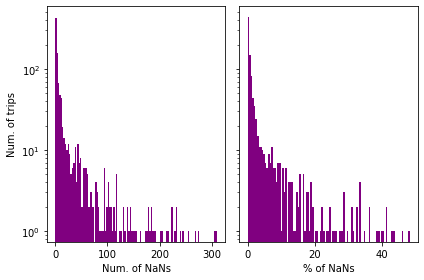

In [338]:
#look at number NaNs to see what the best method for handling them would be
num_nans = [trip.heading_degrees.isna().sum() for trip in trips_train_list]
percent_nans = [100.0*num/len(trip) for num, trip in zip(num_nans, trips_train_list)]

fig, axarr = plt.subplots(1,2, sharey=True)
ax, ax1 = axarr
_,_,_ = ax.hist(num_nans, 
                bins='auto', 
                color='purple', 
                log=True)
_,_,_ = ax1.hist(percent_nans, 
                 bins='auto', 
                 color='purple', 
                 log=True)
ax.set_ylabel('Num. of trips')
ax.set_xlabel('Num. of NaNs')
ax1.set_xlabel('% of NaNs')
fig.tight_layout()

From the dsitribution of NaNs in the trip data, it is clear that some trips have a high percentage of NaNs (almost 50% at worst).  To get a sense for what the worst case looks like, the trip with the highest percentage of NaNs is shown below.

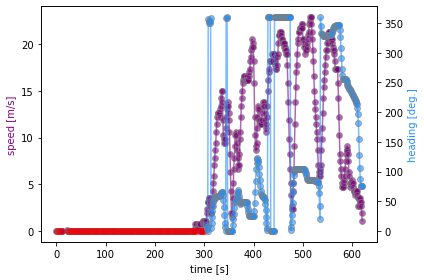

In [339]:
#look at trip with higest percentage of NaNs
trip_max_nan = np.array(trips_train_list, dtype=object)[percent_nans==np.amax(percent_nans)][0]

time = trip_max_nan.time_seconds
speed = trip_max_nan.speed_meters_per_second

heading = trip_max_nan.heading_degrees
nan_mask = trip_max_nan.heading_degrees.isna()
zeros = np.zeros(len(time))

fig, ax = plt.subplots()
ax.plot(time, speed, '-o', c='purple', alpha=0.6, mec='grey')
ax2 = ax.twinx()
ax2.plot(time, heading, '-o', c='dodgerblue', alpha=0.6, mec='grey')
ax.plot(time[nan_mask], zeros[nan_mask], '-o',c='red', alpha=0.1)
#ax2.set_ylim(0,360)
ax.set_xlabel('time [s]')
ax.set_ylabel('speed [m/s]', color='purple')
ax2.set_ylabel('heading [deg.]', color='dodgerblue')
fig.tight_layout()

From the speed and heading data, a few things become clear.  In this case, it seems like there was an error in heading for the beginning half of this trip (red data points).  The speed during this time was close to zero, so this seems like a systematic error in the trip data during those times.  It could be due to a stationary phone (i.e. they weren't driving until almost the 300 sec. time point in this data), or due to another source of error.  Regardless, it seems like the rest of the data is representative of someone driving, so cleaning this trip would consist of dropping the data points where the heading is NaN.

As a strategy to clean the data, all rows with NaNs will be dropped.  In principle, a more sophisticated imputing strategy could be implemented to replace some NaNs with neighboring values if they are isolated.

Also, the heading shows phase jumps as the phone heading goes past 360 or 0.  This is simply due to the fact that heading is modulo 360.  These jumps can be removed by unwrapping the heading.

In [340]:
#simply drop rows with NaN heading for each trip
for df in tqdm(trips_train_list):
    df.dropna(inplace=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [341]:
# unwrap heading to remove phase jumps in heading
for df in tqdm(trips_train_list):
    df.heading_degrees = np.rad2deg(np.unwrap(np.deg2rad(df.heading_degrees)))

  0%|          | 0/1000 [00:00<?, ?it/s]

Now, the trip with the known number of stops and turns (0001.csv) can be visualized.  The 9 turns and 1 stop can be seen clearly in the data.

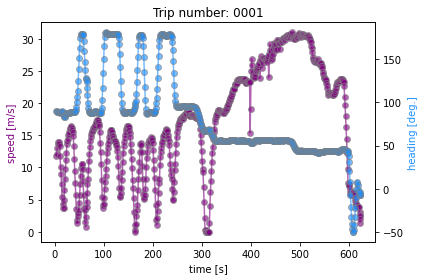

In [342]:
# plot speed and heading vs time for trip with known number of stops and turns
# idx changes the trip that is plotted idx=1 is trip 0001.csv
idx = 1
time = np.array(trips_train_list[idx].time_seconds)
speed = np.array(trips_train_list[idx].speed_meters_per_second)
heading = np.array(trips_train_list[idx].heading_degrees)

fig, ax = plt.subplots()
ax.plot(time, speed, '-o', c='purple', alpha=0.6, mec='grey')
ax2 = ax.twinx()
ax2.plot(time, heading, '-o', c='dodgerblue', alpha=0.6, mec='grey')
#ax2.set_ylim(0,360)
ax.set_xlabel('time [s]')
ax.set_ylabel('speed [m/s]', color='purple')
ax2.set_ylabel('heading [deg.]', color='dodgerblue')
title=fnames_trip_train[idx].split('\\')[-1].split('.')[0]
ax.set_title(f"Trip number: {title}")
fig.tight_layout()

<a id='feature_extraction'></a>
## 3.) Feature extraction: turns and stops

In this section, the algorithm to extract the turn and stop features is developed and tested on trip 0001.csv (other trips can be visualized by changing the variable idx below).

<a id='turn_alg'></a>
### Turns
The algorithm for finding the number of turns is as follows:

1. Interpolate the heading data and resample at a fixed sampling rate of 1 Hz.  This is done to ensure that there is uniform spacing between each data point.  (The sampling rate was nominally 1 Hz, but due to dropped NaNs or measurement error it wasn't always 1 Hz.)
2. Convolve the heading with an appropriate window function ($\tilde{\theta}(t)=\theta(t)\circledast W(t)$).  In this case, a boxcar window of width 3 seconds was chosen.  The window width corresponds to the smallest duration of an event.  This smoothing is done because differentiation of data (the next step) can be sensitive to noise.
3. Differetiate the smoothed heading $\tilde{\theta}(t)$.  Since a turn is step-like feature in heading, the absolute value of the derivative, $\lvert\mathrm{d}\tilde{\theta}(t)/\mathrm{d t}\rvert$, will show each turn as a peak.  Scipy has a find_peaks function that can easily locate these peaks and extract their widths, heights, and other parameters.  The minimum peak width and separation between peaks are hyperparameters that can be tuned.  They were selected to enforce the rule that an event must be longer than 3 seconds and that events within 3 seconds of each other are the same.
4. From this list of peaks, turns are selected based upon the change in heading across the width of the peak.  Only turns with a change in heading greater than 50 degrees are kept.

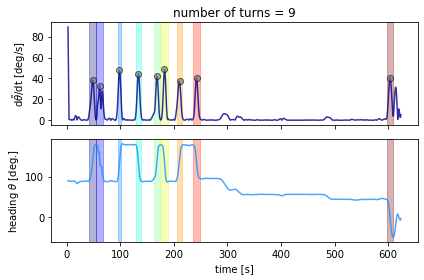

In [343]:
# idx changes the trip that is plotted idx=1 is trip 0001.csv
# idx=4 shows more stops (num_stops=5) to better highlight the stop algorithm 
idx = 1
time = np.array(trips_train_list[idx].time_seconds)
speed = np.array(trips_train_list[idx].speed_meters_per_second)
heading = np.array(trips_train_list[idx].heading_degrees)


# interpolate heading data for uniform sampling
heading_interp = interp1d(time, heading, kind='cubic', fill_value='extrapolate')
step=1
time_resampled = np.arange(np.amin(time), np.amax(time) + step/2.0, step)
heading_resampled = heading_interp(time_resampled)

# apply convolution with window function
window = windows.boxcar(3)
heading_filtered = np.convolve(heading_resampled, window, mode='same')

# differentiate and take absolute value
grad = np.gradient(heading_filtered, time_resampled)
grad_abs = np.abs(grad)

# find the peaks!
peaks, properties = find_peaks(grad_abs, width=3, distance=3, height=5, rel_height=0.9)

# set threshold value for what is considered a turn
turn_threshold = 60

# select peaks based on threshold value
peak_mask = []
for i, (peak, width) in enumerate(zip(peaks, properties['widths'])):
    try:
        heading_diff = np.abs(heading[int(peak-width/2)] - heading[int(peak+width/2)])
    except IndexError:
        heading_diff=0
    if heading_diff>turn_threshold:
        peak_mask.append(True)
    else:
        peak_mask.append(False)
peaks = peaks[peak_mask]
for p in properties:
    properties[p][peak_mask]

# get number of turns
num_turns = len(peaks)

# plot trip and denote turns with a shaded region
cmap = plt.get_cmap('jet',len(peaks))
fig, axarr = plt.subplots(2, sharex=True)
ax,ax1=axarr
ax.plot(time_resampled, grad_abs, c='darkblue', alpha=0.8)
ax.plot(time_resampled[peaks], grad_abs[peaks], 'o', c='grey', alpha=0.6, mec='black')
ax1.plot(time_resampled, heading_resampled, c='dodgerblue', alpha=0.8)
for i, (peak, width) in enumerate(zip(peaks, properties['widths'])):
    xleft = time_resampled[peak] - width/2
    xright = time_resampled[peak] + width/2
    ax.axvspan(xleft, xright, alpha=0.3, color=cmap(i))
    ax1.axvspan(xleft, xright, alpha=0.3, color=cmap(i))
ax1.set_xlabel('time [s]')
ax1.set_ylabel('heading $\\theta$ [deg.]')
ax.set_ylabel('$\\mathrm{d}\\tilde{\\theta} / \\mathrm{dt}$ [deg/s]')
ax.set_title(f'number of turns = {num_turns}')
fig.tight_layout()

<a id='stop_alg'></a>
### Stops
The algorithm for finding the number of stops is as follows:

1. Interpolate the speed data and resample at a fixed sampling rate of 1 Hz.  This is done to ensure that there is uniform spacing between each data point.  (The sampling rate was nominally 1 Hz, but due to dropped NaNs or measurement error it wasn't always 1 Hz.)
2. Apply a threshold speed.  Any time points where the speed is below a threshold (in this case 0.1 m/s) is considered as the car being stopped.  
3. To determine the number of stops that meet the criteria for an event to be considered a stop, clustering is done on the set of times where the car is delow the threshold speed.  DBSCAN is the method that is used here becuase it can account for noise, and it won't force all data points to be in a cluster (as would be the case with k-NN).  It will determine the number of clusters based on the hyperparameters eps and min_samples.  eps and min_samples set the denisty required to form and cluster and the sensitivity to noise.  In this case, eps=3 and min_samples=3 to try and enforce the criteria for an event to be considered a stop.

In [344]:
#get number of stops from data

# interpolate the speed data to apply uniform sampling
speed_interp = interp1d(time, speed, kind='cubic', fill_value='extrapolate')
step = 1 #[sec]
time_resampled = np.arange(np.amin(time), np.amax(time) + step/10, step)
speed_resampled = speed_interp(time_resampled)

# apply simple threshold to get points where the speed is close to 0
speed_mask = speed_resampled<0.1

# Use DBSCAN clustering to determine the number of stops
clustering = DBSCAN(eps=3, min_samples=3, n_jobs=-2).fit(time_resampled[speed_mask].reshape(-1, 1))
n_clusters_ = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)

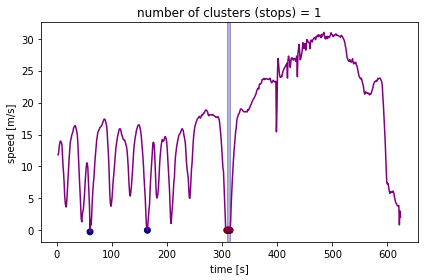

In [345]:
# Plot the location of each stop to verify
# window of time that is considered a top is highlighted by the shaded region
cmap = plt.get_cmap('jet',n_clusters_+1)
fig, ax = plt.subplots()
ax.plot(time_resampled, speed_resampled, c='purple')
ax.scatter(time_resampled[speed_mask], speed_resampled[speed_mask], c=clustering.labels_, cmap='jet')
for i,lab in enumerate(set(clustering.labels_)):
    tmin = np.amin(time_resampled[speed_mask][clustering.labels_==lab])
    tmax = np.amax(time_resampled[speed_mask][clustering.labels_==lab])
    if lab==-1:
        alpha=0.0
    else:
        alpha=0.3
    ax.axvspan(tmin, tmax, alpha=alpha, color=cmap(i))
ax.set_xlabel('time [s]')
ax.set_ylabel('speed [m/s]')
ax.set_title(f'number of clusters (stops) = {n_clusters_}')
fig.tight_layout()

These algorithms seem to be working, so they are wrapped into functions to apply to the entire dataset.

In [346]:
def trip_time_speed_heading(fname, folder):
    """Return time, speed, and unwrapped heading of a trip with a given filename and folder."""
    df = pd.read_csv(os.path.join(folder, fname))
    df.dropna(inplace=True)
    df.heading_degrees = np.rad2deg(np.unwrap(np.deg2rad(df.heading_degrees)))
    time = np.array(df.time_seconds)
    speed = np.array(df.speed_meters_per_second)
    heading = np.array(df.heading_degrees)
    return time, speed, heading

def get_turns(fname, folder=folder_trip_train):
    """
    Determine the number of turns in a given trip based on a peak finding algorithm.
    
    Parameters
    ----------
    fname : str
        filename of the trip.
    folder : str
        folder that the trip file is contained in. Default value is folder_trip_train.

    Returns
    -------
    num_turns : int
        Number of turns detected in the trip
    """
    time, speed, heading = trip_time_speed_heading(fname, folder)
    heading_interp = interp1d(time, heading, kind='cubic', fill_value='extrapolate')
    step = 1 #[sec]
    time_resampled = np.arange(np.amin(time), np.amax(time) + step/10, step)
    heading_resampled = heading_interp(time_resampled)
    
    window = windows.boxcar(3)
    
    heading_filtered = np.convolve(heading_resampled, window, mode='same')
    
    grad = np.gradient(heading_filtered, time_resampled)
    grad_abs = np.abs(grad)
    
    peaks, properties = find_peaks(grad_abs, width=3, distance=3, height=5, rel_height=0.9)
    
    turn_threshold = 60

    peak_mask = []
    for i, (peak, width) in enumerate(zip(peaks, properties['widths'])):
        try:
            heading_diff = np.abs(heading[int(peak-width/2)] - heading[int(peak+width/2)])
        except IndexError:
            heading_diff=0
        if heading_diff>turn_threshold:
            peak_mask.append(True)
        else:
            peak_mask.append(False)

    peaks = peaks[peak_mask]
    
    for p in properties:
        properties[p][peak_mask]
        
    num_turns = len(peaks)
    return num_turns

def get_stops(fname, speed_thresh=0.1, folder=folder_trip_train):
    """
    Determine the number of stops in a given trip based on a speed threshold and the DBSCAN clustering algorithm.
    
    Parameters
    ----------
    fname : str
        Filename of the trip.
    speed_thresh : float
        Threshold speed used to determine if the phone/vehicle is not moving. Speeds below this threshold 
        are used in the clustering algorithm to determine number of stops.  Default value is 0.1
    folder : str
        folder that the trip file is contained in. Default value is folder_trip_train.

    Returns
    -------
    num_stops : int
        Number of stops detected in the trip.
    """
    time, speed, heading = trip_time_speed_heading(fname, folder)
    speed_interp = interp1d(time, speed, kind='cubic', fill_value='extrapolate')
    step = 1 #[sec]
    time_resampled = np.arange(np.amin(time), np.amax(time) + step/10, step)
    speed_resampled = speed_interp(time_resampled)
    speed_mask = speed_resampled<speed_thresh
    if np.sum(speed_mask)==0:
        n_clusters_ = 0
    else:
        clustering = DBSCAN(eps=3, min_samples=3, n_jobs=-2).fit(time_resampled[speed_mask].reshape(-1, 1))
        n_clusters_ = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)
    return n_clusters_

In [347]:
# test feature extraction on different trips
fn = '0001.csv'
print(f'Number of turns = {get_turns(fn)}')
print(f'Number of stops = {get_stops(fn)}')

Number of turns = 9
Number of stops = 1


In [348]:
# apply feature extraction to df
tqdm.pandas()
df_model_train['turns'] = df_model_train.progress_apply(lambda row : get_turns(row['filename']), axis=1)
df_model_train['stops'] = df_model_train.progress_apply(lambda row : get_stops(row['filename']), axis=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [349]:
#Taking a look at the number of turns and stops 
df_model_train[["turns", "stops"]].describe(percentiles=[0.25,0.5,0.75,0.95])

,turns,stops
count,1000.000000,1000.000000
mean,4.328000,3.521000
std,3.077318,2.794525
min,0.000000,0.000000
25%,2.000000,1.000000
50%,4.000000,3.000000
75%,6.000000,5.000000
95%,10.000000,9.000000
max,17.000000,18.000000


In [350]:
# look at correlation matrix to get a sense of features 
corr = df_model_train.drop(columns=['filename'], inplace=False).corr()
corr.style.background_gradient(cmap='RdBu')

,feature1,feature3,feature4,feature5,feature7,feature9,feature11,feature12,feature14,y,turns,stops
feature1,1.000000,-0.024546,0.076748,-0.010892,0.013701,-0.005926,0.001459,-0.030209,0.000703,-0.197324,0.012401,-0.029742
feature3,-0.024546,1.000000,0.049156,0.015374,-0.003785,0.039904,0.036565,-0.034086,0.014839,-0.100206,-0.056769,0.024243
feature4,0.076748,0.049156,1.000000,-0.003980,0.007913,0.031543,-0.005844,-0.029519,-0.024833,-0.191783,0.028419,-0.049680
feature5,-0.010892,0.015374,-0.003980,1.000000,-0.004376,-0.035361,0.032318,0.021280,-0.005600,-0.057884,0.002774,0.000089
feature7,0.013701,-0.003785,0.007913,-0.004376,1.000000,0.032509,-0.016565,-0.013599,0.001717,-0.384853,-0.033853,0.023154
feature9,-0.005926,0.039904,0.031543,-0.035361,0.032509,1.000000,-0.031662,-0.015989,0.017346,-0.471630,-0.044808,0.047560
feature11,0.001459,0.036565,-0.005844,0.032318,-0.016565,-0.031662,1.000000,0.009029,0.054220,0.050918,-0.033560,-0.010022
feature12,-0.030209,-0.034086,-0.029519,0.021280,-0.013599,-0.015989,0.009029,1.000000,0.035037,0.013100,0.004513,0.023815
feature14,0.000703,0.014839,-0.024833,-0.005600,0.001717,0.017346,0.054220,0.035037,1.000000,0.047569,-0.004928,-0.040264
y,-0.197324,-0.100206,-0.191783,-0.057884,-0.384853,-0.471630,0.050918,0.013100,0.047569,1.000000,0.029750,0.005024


<a id='feature_write'></a>

### Write-up: feature extraction
From the descriptive statstitics it seems that the algorithms described above (click here for [turns](#turn_alg) and [stops](#stop_alg)) are working reasonably well.  The number of turns has a broader distribution than stops, as might be expected (i.e. you can make a turn without fully stopping at an intersection).  Further optimization of hyperparameters is probably needed to correctly account for outliers (the max values extracted seems high).  Also, it seems like turns and stops aren't as correlated as I might have expected (only 0.086).  This could reflect an error in the algorithms or an error in my intuition. 

In terms of computational complexity, the turns algorithm is much simpler than the stops algorithm.  It is based on simple calculus, so it has the advantage of being easily interpretable.  The stop algorithm is more obfuscated becuase it is relying on a complicated clustering algorithm.  Furthermore, I expect that the turn algorithm will fare better than the stop algorithm as the datasets become larger because DBSCAN is not memory efficient.  It seems to work well enough for these smaller datasets, but a more efficient algorithm would probably be need to be implemented for larger datasets.

<a id='model_dev'></a>
## 4.) Model development and validation

In this section a model is developed and validated to determine whether or not a trip is "interesting," as indicated by the binary label {0,1}.

# <a id='model_write'></a>

### Write-up: model description and performance

The general approach taken to developing this model is as follows:

1. The provided training data is split into a training and validation data set.  The model is only trained on the training data, and its out-of-sample performance is tested by applying it to the validation data set.
2. The model consists of a pipeline of scaling, dimension reduction using PCA, and classification. The classification model that is used herein is Logistic Regression.  This means that the output of the model is the probability that a trip is interesting (label=1).  A probability cutoff is applied to make a prediction on whether the trip is interesting (prob>cutoff --> label=1). This cutoff is treated as a hyperparameter.
3. Optimization of hyperparameters (except for the probability cutoff) is done using a cross-validated grid-search over a set range of parameters.  The score used to determine the optimal parameters is the ROC AUC.  Using the AUC allows for optimization before setting a specific probability cutoff.
4. Optimal probability cutoffs are determined using both Youden's J statistic and maximum f1 score.

This method produces a model that achieves a high AUC score on the training data (AUC=0.932) for the parameters:
    
    RobustScaler quantiles = (5, 95)
    PCA n_components = 11,
    LogReg regularization C=10,
    LogReg penalty = L2

The two methods for determining the optimal probability cutoff (J statistic and max f1 score) produce different cutoffs and therefore different accuracy, precision, and recall scores on the training data set.  The cutoff determined using the max f1 score gives a higher precision score, so that is the one that is selected (probability cutoff = 0.420).

Thus, the in-sample performace scores for this model are:
    
    0.870 as the training set accuracy.
    0.765 as the training set precision.
    0.839 as the training set recall.

Applying this model to the validation data set gives a sense for the out-of-sample metrics for this model, and they are

    0.867 as the validation set accuracy.
    0.805 as the validation set precision.
    0.753 as the validation set recall.
    
    
These scores seem reasonably good.  Ideally, different classification models would be applied to find the optimal model, however I chose to focus on optimizing one model rather than throw several models at the problem.  Logistic regression was my first choice because it is a relatively straightforward model that can be interpreted.

In [351]:
# separate df into X and y
X = df_model_train.drop(columns=['filename', 'y'], inplace=False)
y = df_model_train.y

In [352]:
# train_test_split to separate training data into a set that will be used for model traing 
#   and a set that will be used for validation
X_train,X_val,y_train,y_val = train_test_split(X,y,
                                               test_size=.3,
                                               stratify=y,
                                               shuffle=True,
                                               random_state=908)

In [353]:
# create pipeple to simplify model optimization
# scale -> dimesnion reduction -> classifier
pipe = Pipeline([('scaler', RobustScaler()),
                ('PCA', PCA()),
                ('logreg', LogisticRegression(solver='liblinear', max_iter=1000))])

# determine hyperparamters that need to be optimized for the model
quartiles_to_test = [(25,75),(5,95)]
n_components_to_test = np.arange(1, len(X.columns)+1)
C_to_test = 10**np.arange(-2,4, 0.1)
penalties_to_test = ['l1', 'l2']
params = {'scaler__quantile_range': quartiles_to_test,
          'PCA__n_components': n_components_to_test,
          'logreg__C': C_to_test,
         'logreg__penalty': penalties_to_test}
scoring = {'AUC':'roc_auc'}
refit = 'AUC'

In [354]:
# perform gridsearch to find optimal parameters for PCA and LogReg
# NOTE: For reference, this takes ~20 sec. to run on my machine with 16 threads. It will be significantly slower on a latptop.
gridsearch = GridSearchCV(pipe, params, scoring=scoring, refit=refit, n_jobs=-2, verbose=1).fit(X_train, y_train)

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  20 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-2)]: Done 575 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-2)]: Done 4575 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-2)]: Done 10175 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-2)]: Done 14400 out of 14400 | elapsed:   17.1s finished


In [355]:
#get final score from gridsearch
print(f'Final {refit} score is {gridsearch.score(X_train, y_train):.3f}')

Final AUC score is 0.933


In [356]:
# optimal parameters from the gridsearch
gridsearch.best_params_

{'PCA__n_components': 11,
 'logreg__C': 10.000000000000062,
 'logreg__penalty': 'l2',
 'scaler__quantile_range': (5, 95)}

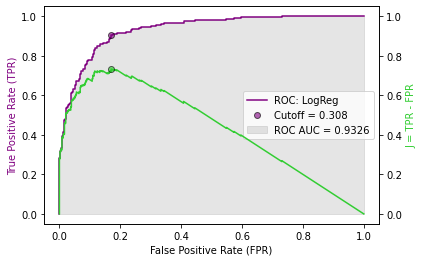

In [367]:
# get predicted probabilites from model
probs = gridsearch.predict_proba(X_train)

# get tpr, fpr, and ROC AUC
auc = roc_auc_score(y_train,probs[:,1])
fpr,tpr,cutoffs = roc_curve(y_train,probs[:,1])

# Calculate Youden's J statistic to find optimal cutoff based on ROC
J = tpr - fpr
cutoff_max_J = cutoffs[np.argmax(J)]
tpr_max_J = tpr[np.argmax(J)]
fpr_max_J = fpr[np.argmax(J)]
max_J = np.amax(J)

# Plot ROC and J statistic for the best model and highlight cutoff that maximizes the J statistic
fig, ax = plt.subplots()
ax.plot(fpr, tpr, c='purple', label='ROC: LogReg')
ax.fill_between(fpr, 0, tpr, color='grey', alpha=0.2, label=f'ROC AUC = {auc:.4f}')
ax.plot(fpr_max_J, tpr_max_J, 'o', c='purple', mec='black', alpha=0.6, label=f'Cutoff = {cutoff_max_J:.3f}')
ax.set_xlabel('False Positive Rate (FPR)')
ax.set_ylabel('True Positive Rate (TPR)', color='purple')
ax2 = ax.twinx()
ax2.plot(fpr, J, color='limegreen')
ax2.set_ylabel('J = TPR - FPR', color='limegreen')
ax2.plot(fpr_max_J, max_J, 'o', c='limegreen', mec='black', alpha=0.6)
ax2.set_ylim(ax.get_ylim())
ax.legend(loc='center right');

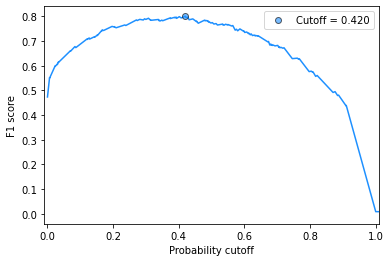

In [358]:
# define function to apply probability cutoff to predicted probabilities from model
def predict_with_cutoff(probability, cutoff):
    '''
    Returns 1 if probability is greater than cutoff, 0 if proabaility is less than cutoff
    '''
    return (probability >= cutoff).astype('int')

# get f1 scores for different cutoffs and get the cutoff with the max f1
scores = [f1_score(y_train, predict_with_cutoff(probs[:,1], cut)) for cut in cutoffs]
max_f1_score = np.amax(scores)
cutoff_max_f1 = cutoffs[np.argmax(scores)]

# plot f1 vs cutoff
fig, ax = plt.subplots()
ax.plot(cutoffs, scores, c='dodgerblue')
ax.plot(cutoff_max_f1, max_f1_score, 'o', c='dodgerblue', mec='black', alpha=0.6, label=f'Cutoff = {cutoff_max_f1:.3f}')
ax.set_xlim(-0.01, 1.01)
ax.set_xlabel('Probability cutoff')
ax.set_ylabel('F1 score')
ax.legend();

In [359]:
# Check metrics on training and validation sets

print('----------------------------------------------------------------------------------')
for cut in [cutoff_max_f1, cutoff_max_J]:
    train_pred = predict_with_cutoff(gridsearch.predict_proba(X_train)[:,1], cut)
    test_pred = predict_with_cutoff(gridsearch.predict_proba(X_val)[:,1], cut)
    print(f'Using a probability cutoff of {cut:.3f}')
    print()
    print(f'The model had {accuracy_score(y_train,train_pred):.3f} as the training set accuracy.')
    print(f'The model had {precision_score(y_train,train_pred):.3f} as the training set precision.')
    print(f'The model had {recall_score(y_train,train_pred):.3f} as the training set recall.')
    print()
    print(f'The model had {accuracy_score(y_val,test_pred):.3f} as the validation set accuracy.')
    print(f'The model had {precision_score(y_val,test_pred):.3f} as the validation set precision.')
    print(f'The model had {recall_score(y_val,test_pred):.3f} as the validation set recall.')
    print('----------------------------------------------------------------------------------')

----------------------------------------------------------------------------------
Using a probability cutoff of 0.420

The model had 0.870 as the training set accuracy.
The model had 0.765 as the training set precision.
The model had 0.839 as the training set recall.

The model had 0.867 as the validation set accuracy.
The model had 0.805 as the validation set precision.
The model had 0.753 as the validation set recall.
----------------------------------------------------------------------------------
Using a probability cutoff of 0.308

The model had 0.853 as the training set accuracy.
The model had 0.705 as the training set precision.
The model had 0.903 as the training set recall.

The model had 0.860 as the validation set accuracy.
The model had 0.743 as the validation set precision.
The model had 0.839 as the validation set recall.
----------------------------------------------------------------------------------


<a id='apply_model'></a>
## 5.) Apply model to make predictions on test data

In [360]:
# get paths and filenames
folder_trip_test = os.path.join(cwd, 'trip_data_test')
fnames_trip_test = glob.glob(os.path.join(folder_trip_test, '*.csv'))
fname_model_test = os.path.join(cwd, 'model_data_test.csv')

# load test data csv
df_model_test = pd.read_csv(fname_model_test)

# look at head of df
df_model_test.head(4)

,filename,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14
0,1000.csv,False,False,True,6.002290,11021.870460,34626.227267,0.000986,5,9,1,1.954513e+02,22.269055,2.014536e+02,5.076019
1,1001.csv,False,False,True,5.886440,11983.807690,37648.242201,0.000997,5,18,1,9.078651e+04,45.626548,9.079240e+04,5.105855
2,1002.csv,True,False,True,5.465596,8028.071307,25220.929841,0.000985,6,15,1,6.150144e+07,501316.506956,6.150145e+07,5.925519
3,1003.csv,False,False,True,4.553190,9232.252788,29003.977535,0.001005,7,7,1,2.743655e+00,0.088515,7.296845e+00,6.895799


In [361]:
# check for NaNs
df_model_test.isna().sum()

filename     0
feature1     0
feature2     0
feature3     0
feature4     0
feature5     0
feature6     0
feature7     0
feature8     0
feature9     0
feature10    0
feature11    0
feature12    0
feature13    0
feature14    0
dtype: int64

In [362]:
# convert booleans to ints
df_model_test['feature1'] = df_model_test['feature1'].replace({True : 1, False : 0})
df_model_test['feature2'] = df_model_test['feature2'].replace({True : 1, False : 0})
df_model_test['feature3'] = df_model_test['feature3'].replace({True : 1, False : 0})

# drop features that were previouslly excluded
df_model_test.drop(columns=['feature6', 'feature13', 'feature8', 'feature10'], inplace=True)

# get number of turns and stops from individual trips 
tqdm.pandas()
df_model_test['turns'] = df_model_test.progress_apply(lambda row : get_turns(row['filename'], folder=folder_trip_test), axis=1)
df_model_test['stops'] = df_model_test.progress_apply(lambda row : get_stops(row['filename'], folder=folder_trip_test), axis=1)

# examine descriptive statistics
df_model_test.describe(percentiles=[0.25,0.5,0.75,0.95])

  0%|          | 0/876 [00:00<?, ?it/s]

  0%|          | 0/876 [00:00<?, ?it/s]

,feature1,feature2,feature3,feature4,feature5,feature7,feature9,feature11,feature12,feature14,turns,stops
count,876.000000,876.000000,876.000000,876.000000,876.000000,876.000000,876.000000,8.760000e+02,8.760000e+02,876.000000,876.000000,876.000000
mean,0.084475,0.001142,0.493151,4.950077,9975.888816,0.001000,10.105023,8.310143e+09,1.272098e+05,4.971353,4.531963,3.454338
std,0.278258,0.033787,0.500239,0.983120,989.478267,0.000010,3.078467,2.395083e+11,3.291249e+06,1.544001,3.110187,2.755809
min,0.000000,0.000000,0.000000,1.977765,6931.340345,0.000967,2.000000,1.734251e-02,3.069171e-07,0.828402,0.000000,0.000000
25%,0.000000,0.000000,0.000000,4.250128,9347.687670,0.000994,8.000000,6.041359e+02,6.936229e-02,3.976782,2.000000,1.000000
50%,0.000000,0.000000,0.000000,4.959677,9984.822398,0.001000,10.000000,2.207838e+04,2.197523e+00,4.990479,4.000000,3.000000
75%,0.000000,0.000000,1.000000,5.667337,10648.719597,0.001007,12.000000,7.059908e+05,6.326998e+01,6.009641,6.000000,5.000000
95%,1.000000,0.000000,1.000000,6.531625,11497.557399,0.001017,15.000000,6.492908e+07,1.197981e+04,7.868939,10.000000,9.000000
max,1.000000,1.000000,1.000000,8.056168,13152.171754,0.001032,19.000000,7.088505e+12,9.723767e+07,10.012947,23.000000,15.000000


In [363]:
# drop filename to get df into form for the model
X_test = df_model_test.drop(columns=['filename'], inplace=False)

In [364]:
# apply model and probability cutoff to make predictions on the test data
test_pred = predict_with_cutoff(gridsearch.predict_proba(X_test)[:,1], cutoff_max_f1)

In [365]:
# create dataframe with predictions
df_predictions = pd.DataFrame(data={'filename':df_model_test.filename, 'prediction':test_pred})
df_predictions.head(4)

,filename,prediction
0,1000.csv,1
1,1001.csv,0
2,1002.csv,0
3,1003.csv,1


In [366]:
# save dataframe
df_predictions.to_csv('test_predictions.csv', index=False)
# Done! Thanks for reading everything!